In [2]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

In [3]:
os.getcwd()

'/home/nick/classwork_21_22/COMP755/COMP755FinalProj/Processing'

In [4]:
def loc_from_binary_array(arr):
    # return loc = (top, right, bottom, left)
    mask_indices = np.argwhere(arr == 0)
    top = np.min(mask_indices[:,0])
    bottom = np.max(mask_indices[:,0])
    left = np.min(mask_indices[:,1])
    right = np.max(mask_indices[:,1])
    return (top, right, bottom, left)


In [5]:
def get_mask_from_face_locations(img, loc):
    mask = np.ones_like(img)
    if not loc:
        return mask
    if len(loc) == 1:
        loc = loc[0]
    mask[loc[0]:loc[2],loc[3]:loc[1],:] = np.zeros_like(mask[loc[0]:loc[2],loc[3]:loc[1],:])
    return mask

In [6]:
img_dir = '../../img_align_celeba_cleaned/'
mask_dir = '../../img_align_celeba_masks/'
save_dir_256 = '../../celeba_256/'
save_dir_256_masked_png = '../../celeba_256_masked_png/'
save_dir_256_masks = '../../celeba_256_masks/'
save_dir_256_masks_pngs_for_gatedconv = '../../celeba_256_masks_pngs_for_gatedconv/'
mask_filenames = sorted(glob(mask_dir + '*'))
img_filenames = sorted(glob(img_dir + '*'))
print(len(mask_filenames), len(img_filenames))

202228 202228


87600
28812
(76, 131, 173, 34)


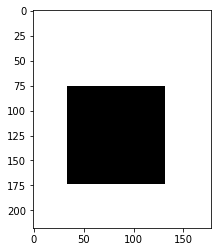

In [7]:
# test loc_from_binary_array
mask_arr = np.load(mask_filenames[0])
plt.imshow(mask_arr.astype(np.float32))
print(np.count_nonzero(mask_arr))
print(np.count_nonzero(1 - mask_arr))
print(loc_from_binary_array(mask_arr))

In [8]:
import pickle

with open('../../objects_jsons/celeba_test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

with open('../../objects_jsons/celeba_train_set.pkl', 'rb') as f:
    train_set = pickle.load(f)

relevant_filenames = [x[0] for x in test_set.union(train_set)]
print(len(relevant_filenames))
print(relevant_filenames[:5])

15038
['043379.jpg', '110923.jpg', '096454.jpg', '109167.jpg', '064586.jpg']


In [9]:
# try to zoom celeba imgs so that they are 256x256 and run
# inference on then with the model that was trained for celebahq imgs
# img_arr = np.asarray(plt.imread(img_filenames[0]))
# buf = (np.array((256,256,3)) - np.array(np.shape(img_arr))) // 2
# print(buf)

for i in range(len(img_filenames)):

    img_f = img_filenames[i]
    mask_f = mask_filenames[i]

    if os.path.basename(img_f) not in relevant_filenames:
        continue

    savename_img = os.path.join(save_dir_256, os.path.basename(img_f) + '_256.png')
    savename_mask = os.path.join(save_dir_256_masks, os.path.basename(img_f) + '_256_mask.npy')
    savename_masked_img = os.path.join(save_dir_256_masked_png, os.path.basename(img_f) + '_256_masked.png')
    savename_mask_png = os.path.join(save_dir_256_masks_pngs_for_gatedconv, os.path.basename(img_f) + '_256_mask.png')

    if os.path.isfile(savename_mask_png):
        continue
    
    mask_arr = np.load(mask_f).astype(np.uint8)
    img_arr = np.asarray(plt.imread(img_f)).astype(np.uint8)
    
    loc = loc_from_binary_array(mask_arr)
    width = img_arr.shape[1]

    avg = (loc[0] + loc[2]) // 2 
    indices = (avg - width // 2, avg + width // 2)

    small_square_img = img_arr[indices[0]:indices[1], :, :]
    # print(small_square_img.shape)

    zoom_factor = 256 / width
    square_img_256 = zoom(small_square_img, (zoom_factor, zoom_factor, 1))
    # print(square_img_256.shape)

    new_small_loc = (loc[0] - indices[0], loc[1], loc[2] - indices[0], loc[3])
    new_big_loc = tuple([i * 256 // 178 for i in new_small_loc])

    # plt.imshow(square_img_256)
    try:
        plt.imsave(savename_img , square_img_256)
    except BaseException as err:
        continue
        print(img_f)
        print(img_arr.shape)
        print(square_img_256.shape)
        print(np.unique(mask_arr))
        print(loc)
        print(np.count_nonzero(1 - mask_arr))
        print(np.count_nonzero(mask_arr))
#         plt.imshow(img_arr * mask_arr)
        plt.imshow(img_arr)
        assert False

    square_mask_256 = get_mask_from_face_locations(square_img_256, new_big_loc)
    square_mask_256 = square_mask_256.astype(np.float32)

    # print(square_mask_256.shape)
    # print(np.max(square_mask_256))
    # print(np.unique(square_mask_256))
    # print(np.max(square_img_256 * square_mask_256))

    np.save(savename_mask, square_mask_256)

    plt.imsave(savename_mask_png, 1 - square_mask_256)
    plt.imsave(savename_masked_img, (square_img_256 * square_mask_256).astype(np.uint8))
    
    # plt.imsave(savename_masked_img, square_img_256 * square_mask_256)
    
    # plt.imshow(square_img_256 * square_mask_256)
    # plt.imsave()
    # break